<h1>Classification using Decision Tree models </h1>

In [102]:
import pickle
from tqdm.notebook import tqdm 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from scipy.sparse import hstack
from scipy import sparse

import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#for 3-d plot
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
#code to load glove vectors 
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

<h3>Implementing Decision Trees

In [5]:
df = pd.read_csv("preprocessed_data.csv")
df.head()

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   
3           ga            mrs          grades_prek_2   
4           wa            mrs             grades_3_5   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   
3                                             2                    1   
4                                             2                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   
3    appliedlearning                    earlydevelopment   
4  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00  
3  i recently read article giving students choice...  481.04  
4  my students crave challenge eat obstacles brea...   17.74

> Segregation of features and Tarrget from the provided dataset.

In [6]:
feature_set = df.drop(columns=['project_is_approved'])
target_set = df['project_is_approved']

> Splitting data into Train and Test data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(feature_set, target_set, test_size =0.23, random_state=78, stratify=target_set)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)  

(84120, 8)
(25128, 8)
(84120,)
(25128,)


### Encoding numerical and categorical data

> For categorical data

In [10]:
one_hot = OneHotEncoder(handle_unknown="ignore")

In [11]:
""" school_state teacher_prefix project_grade_category clean_categories clean_subcategories """

one_hot.fit(x_train[['school_state']])

school_state_train_ohe = one_hot.transform(x_train[['school_state']])
school_state_test_ohe = one_hot.transform(x_test[['school_state']])

print("Shape of train set for School state is :", school_state_train_ohe.shape)
print("Shape of test set for School state is :", school_state_test_ohe.shape)
print("*-*"*20)

one_hot.fit(x_train[['teacher_prefix']])

teacher_prefix_train_ohe = one_hot.transform(x_train[['teacher_prefix']])
teacher_prefix_test_ohe = one_hot.transform(x_test[['teacher_prefix']])

print("Shape of train set for Teacher Prefix is :", teacher_prefix_train_ohe.shape)
print("Shape of test set for Teacher Prefix is :",teacher_prefix_test_ohe.shape)
print("*-*"*20)

one_hot.fit(x_train[['project_grade_category']])

project_grade_category_train_ohe = one_hot.transform(x_train[['project_grade_category']])
project_grade_category_test_ohe = one_hot.transform(x_test[['project_grade_category']])

print("Shape of train set for Project Grade Category is :", project_grade_category_train_ohe.shape)
print("Shape of test set for Project Grade Category is :",project_grade_category_test_ohe.shape)
print("*-*"*20)

one_hot.fit(x_train[['clean_categories']])

clean_categories_train_ohe = one_hot.transform(x_train[['clean_categories']])
clean_categories_test_ohe = one_hot.transform(x_test[['clean_categories']])

print("Shape of train set for Clean Categories is :", clean_categories_train_ohe.shape)
print("Shape of test set for Clean Categories is :",clean_categories_test_ohe.shape)
print("*-*"*20)

one_hot.fit(x_train[['clean_subcategories']])

clean_subcategories_train_ohe = one_hot.transform(x_train[['clean_subcategories']])
clean_subcategories_test_ohe = one_hot.transform(x_test[['clean_subcategories']])

print("Shape of train set for Clean Subcategories is :", clean_subcategories_train_ohe.shape)
print("Shape of test set for Clean Subcategories is :",clean_subcategories_test_ohe.shape)
print("*-*"*20)


Shape of train set for School state is : (84120, 51)
Shape of test set for School state is : (25128, 51)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
Shape of train set for Teacher Prefix is : (84120, 5)
Shape of test set for Teacher Prefix is : (25128, 5)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
Shape of train set for Project Grade Category is : (84120, 4)
Shape of test set for Project Grade Category is : (25128, 4)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
Shape of train set for Clean Categories is : (84120, 51)
Shape of test set for Clean Categories is : (25128, 51)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*
Shape of train set for Clean Subcategories is : (84120, 395)
Shape of test set for Clean Subcategories is : (25128, 395)
*-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-**-*


> For numerical data

In [12]:
nv = Normalizer()

In [13]:
""" teacher_number_of_previously_posted_projects price """


nv.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

teacher_number_of_previously_posted_projects_train_nv = nv.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
teacher_number_of_previously_posted_projects_test_nv = nv.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

nv.fit(x_train['price'].values.reshape(-1,1))

price_train_nv = nv.transform(x_train['price'].values.reshape(-1,1))
price_test_nv = nv.transform(x_test['price'].values.reshape(-1,1))

### Encoding column Essay

> TF_IDF Vectorisation

In [15]:
features_of_tfidf_unigrams = []

tfidf_uni = TfidfVectorizer(min_df= 100) # vectorizer to consider only unigrams (Shape of matrix after TF-IDF -> Essay: x_train:  (84120, 15056)
                                                                              #  Shape of matrix after TF-IDF -> Essay: x_test :  (25128, 15056)) using min_df=10
tfidf_uni.fit(x_train['essay'].values)

tfidf_train_essay_uni = tfidf_uni.transform(x_train['essay'].values)
tfidf_test_essay_uni = tfidf_uni.transform(x_test['essay'].values)

features_of_tfidf_unigrams.extend(tfidf_uni.get_feature_names())

print("Shape of matrix after TF-IDF -> Essay: x_train: ",tfidf_train_essay_uni.shape)
# print("Shape of matrix after TF-IDF -> Essay: x_cv   : ",x_cv_essays_tfidf.shape)
print("Shape of matrix after TF-IDF -> Essay: x_test : ",tfidf_test_essay_uni.shape)


Shape of matrix after TF-IDF -> Essay: x_train:  (84120, 5514)
Shape of matrix after TF-IDF -> Essay: x_test :  (25128, 5514)


In [16]:
features_of_tfidf_bigrams = []

tfidf_bi = TfidfVectorizer(min_df= 100, ngram_range=(1,2), max_features=75000) # vectorizer to unigrams and bigrams, also setting parameter max_features = 75000 as
                                                                             # 150877 feautes got extracted using min_df = 10, which can take longer time for computations
tfidf_bi.fit(x_train['essay'].values)

tfidf_train_essay_bi = tfidf_bi.transform(x_train['essay'].values)
tfidf_test_essay_bi = tfidf_bi.transform(x_test['essay'].values)

features_of_tfidf_bigrams.extend(tfidf_bi.get_feature_names())

print("Shape of matrix after TF-IDF -> Essay: x_train: ",tfidf_train_essay_bi.shape)

print("Shape of matrix after TF-IDF -> Essay: x_test : ",tfidf_test_essay_bi.shape)


Shape of matrix after TF-IDF -> Essay: x_train:  (84120, 18643)
Shape of matrix after TF-IDF -> Essay: x_test :  (25128, 18643)


> TFIDF Word to Vec vectorization

In [17]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [18]:
# average Word2Vec on train data
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

  0%|          | 0/84120 [00:00<?, ?it/s]

84120
300


In [19]:
# average Word2Vec on train data
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

  0%|          | 0/25128 [00:00<?, ?it/s]

25128
300


#### Sentiment Analysis

> Sentiment analysis for Training Data

In [23]:
sid = SentimentIntensityAnalyzer()

essay_train =x_train["essay"].values
essay_train_sentiment_score = []

for sentence in tqdm(essay_train):
    res = sid.polarity_scores(sentence)
    essay_train_sentiment_score.append(res['compound'])
    
x_train['essay_sentiment_train'] = essay_train_sentiment_score

x_train.head()

  0%|          | 0/84120 [00:00<?, ?it/s]

school_state teacher_prefix project_grade_category  \
55447           ky             ms             grades_6_8   
9396            fl             ms          grades_prek_2   
42546           ms            mrs             grades_3_5   
43861           fl            mrs          grades_prek_2   
50597           ca            mrs          grades_prek_2   

       teacher_number_of_previously_posted_projects  \
55447                                            13   
9396                                              9   
42546                                             9   
43861                                            15   
50597                                             3   

                     clean_categories               clean_subcategories  \
55447                    math_science                   appliedsciences   
9396                literacy_language                          literacy   
42546                      music_arts                        visualarts   
43861  math_science literacy_language     environmentalscience literacy   
50597   appliedlearning health_sports  earlydevelopment health_wellness   

                                                   essay   price  \
55447  i work title one school urban area i donorscho...  293.13   
9396   i teach pretty amazing first grade students 6 ...   89.48   
42546  each day 75 100 wildcat artists come explore c...  115.40   
43861  you could hear pin drop classroom read aloud t...   99.98   
50597  my students part community impoverished underp...  173.98   

       essay_sentiment_train  
55447                 0.9955  
9396                  0.9947  
42546                 0.9969  
43861                 0.9891  
50597                 0.9861

> Sentiment score for test data

In [24]:
sid = SentimentIntensityAnalyzer()

essay_test = x_test["essay"]
essay_test_sentiment_score = []

for sentence in tqdm(essay_test):
    res = sid.polarity_scores(sentence)
    essay_test_sentiment_score.append(res['compound'])
    
x_test['essay_sentiment_test'] = essay_test_sentiment_score

x_test.head()

  0%|          | 0/25128 [00:00<?, ?it/s]

school_state teacher_prefix project_grade_category  \
98359           wa            mrs          grades_prek_2   
39490           ca            mrs          grades_prek_2   
25073           tx            mrs          grades_prek_2   
95977           oh             ms             grades_3_5   
26951           ny             ms             grades_6_8   

       teacher_number_of_previously_posted_projects  \
98359                                             2   
39490                                             4   
25073                                             8   
95977                                             6   
26951                                            20   

                       clean_categories          clean_subcategories  \
98359                 literacy_language  literacy literature_writing   
39490                   appliedlearning             earlydevelopment   
25073  history_civics literacy_language   financialliteracy literacy   
95977                 literacy_language                     literacy   
26951                 literacy_language  literacy literature_writing   

                                                   essay   price  \
98359  my students always first set smiles i see walk...  199.00   
39490  my eager learners excited process information ...  479.00   
25073  my students growing learning everyday we tight...  543.13   
95977  i want all students not ready fourth grade als...  368.95   
26951  my students vary age 12 17 they diverse learne...   92.33   

       essay_sentiment_test  
98359                0.9624  
39490                0.9956  
25073                0.9855  
95977                0.9967  
26951                0.9844

In [25]:
sentiment_test=x_test['essay_sentiment_test'].values.reshape(-1,1)
sentiment_train=x_train['essay_sentiment_train'].values.reshape(-1,1)

## Merging features

<ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
</ul>

> TFIDF using unigrams

In [27]:
tfidf_train_set_uni = hstack((school_state_train_ohe, teacher_prefix_train_ohe, project_grade_category_train_ohe, clean_categories_train_ohe, clean_subcategories_train_ohe, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_train_essay_uni, sentiment_train)).tocsr()

tfidf_test_set_uni = hstack((school_state_test_ohe, teacher_prefix_test_ohe, project_grade_category_test_ohe, clean_categories_test_ohe, clean_subcategories_test_ohe, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_test_essay_uni, sentiment_test)).tocsr()

In [28]:
print(tfidf_train_set_uni.shape)
print(tfidf_test_set_uni.shape)

(84120, 6023)
(25128, 6023)


> TFIDF using bigrams

In [29]:
tfidf_train_set_bi = hstack((school_state_train_ohe, teacher_prefix_train_ohe, project_grade_category_train_ohe, clean_categories_train_ohe, clean_subcategories_train_ohe, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_train_essay_bi, sentiment_train)).tocsr()

tfidf_test_set_bi = hstack((school_state_test_ohe, teacher_prefix_test_ohe, project_grade_category_test_ohe, clean_categories_test_ohe, clean_subcategories_test_ohe, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_test_essay_bi, sentiment_test)).tocsr()

In [30]:
print(tfidf_train_set_bi.shape)
print(tfidf_test_set_bi.shape)

(84120, 19152)
(25128, 19152)


<ul>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>       
</ul>

In [31]:
w2v_train_set = hstack((school_state_train_ohe, teacher_prefix_train_ohe, project_grade_category_train_ohe, clean_categories_train_ohe, clean_subcategories_train_ohe, teacher_number_of_previously_posted_projects_train_nv, price_train_nv, tfidf_w2v_vectors, sentiment_train)).tocsr()

w2v_test_set = hstack((school_state_test_ohe, teacher_prefix_test_ohe, project_grade_category_test_ohe, clean_categories_test_ohe, clean_subcategories_test_ohe, teacher_number_of_previously_posted_projects_test_nv, price_test_nv, tfidf_w2v_vectors_test, sentiment_test)).tocsr()

In [32]:
print(w2v_train_set.shape)
print(w2v_test_set.shape)

(84120, 809)
(25128, 809)


## Hyperparameter Tuning

> <h2>For Set 1(Data with unigrams only)</h2>

In [34]:
dt_classifier_set1 = DecisionTreeClassifier()

parameters = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}

grid_search = GridSearchCV(dt_classifier_set1,parameters, cv= 5, scoring='roc_auc',return_train_score=True,n_jobs=-1)
grid_search.fit(tfidf_train_set_uni, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [35]:
train_auc_set1_uni= grid_search.cv_results_['mean_train_score']
train_auc_std_set1_uni= grid_search.cv_results_['std_train_score']
cv_auc_set1_uni = grid_search.cv_results_['mean_test_score']
cv_auc_std_set1_uni= grid_search.cv_results_['std_test_score']
bestMaxDepth_set1_uni=grid_search.best_params_['max_depth']
bestMinSampleSplit_set1_uni=grid_search.best_params_['min_samples_split']
bestScore_set1_uni=grid_search.best_score_

In [36]:
print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

Train Scores: [0.55134692 0.55134692 0.55134692 0.55134692 0.5864862  0.5864862
 0.5864862  0.5864862  0.67040403 0.6695898  0.66549052 0.66051333
 0.80821869 0.80312457 0.77674816 0.74245818]
CV Scores :[0.55018158 0.55018158 0.55018158 0.55018158 0.58068982 0.58068982
 0.58068982 0.58068982 0.6231503  0.62431323 0.626994   0.62914536
 0.56955486 0.57071408 0.59234906 0.61456564]


In [37]:
"""dt_classifier_set1_bal = DecisionTreeClassifier(class_weight='balanced')

parameters = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}

grid_search = GridSearchCV(dt_classifier_set1_bal,parameters, cv= 3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
grid_search.fit(tfidf_train_set_uni, y_train)

print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

print(" BEST SCORE: ",grid_search.best_score_) """   # BEST SCORE:  0.6265938712217426

'dt_classifier_set1_bal = DecisionTreeClassifier(class_weight=\'balanced\')\n\nparameters = {\'max_depth\':[1, 3, 10, 30],\'min_samples_split\':[5, 10, 100, 500]}\n\ngrid_search = GridSearchCV(dt_classifier_set1_bal,parameters, cv= 3, scoring=\'roc_auc\',return_train_score=True,n_jobs=-1)\ngrid_search.fit(tfidf_train_set_uni, y_train)\n\nprint("Train Scores: "+ str(grid_search.cv_results_[\'mean_train_score\']))\nprint("CV Scores :" + str(grid_search.cv_results_[\'mean_test_score\']))\n\nprint(" BEST SCORE: ",grid_search.best_score_) '

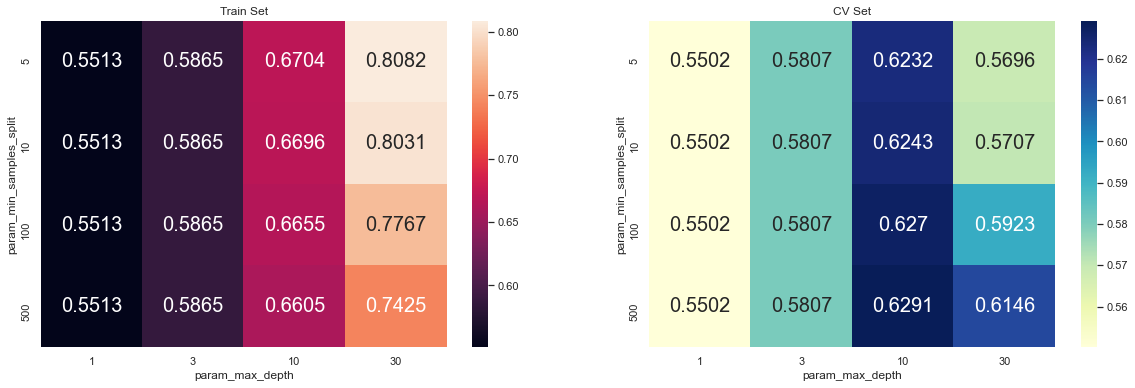

In [38]:
max_scores1 = pd.DataFrame(grid_search.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [39]:
print("BEST MAX DEPTH: ",grid_search.best_params_['max_depth'],"\nBEST SCORE: ",grid_search.best_score_,"\nBEST MIN SAMPLE SPLIT: ",grid_search.best_params_['min_samples_split'])

BEST MAX DEPTH:  10 
BEST SCORE:  0.6291453610914258 
BEST MIN SAMPLE SPLIT:  500


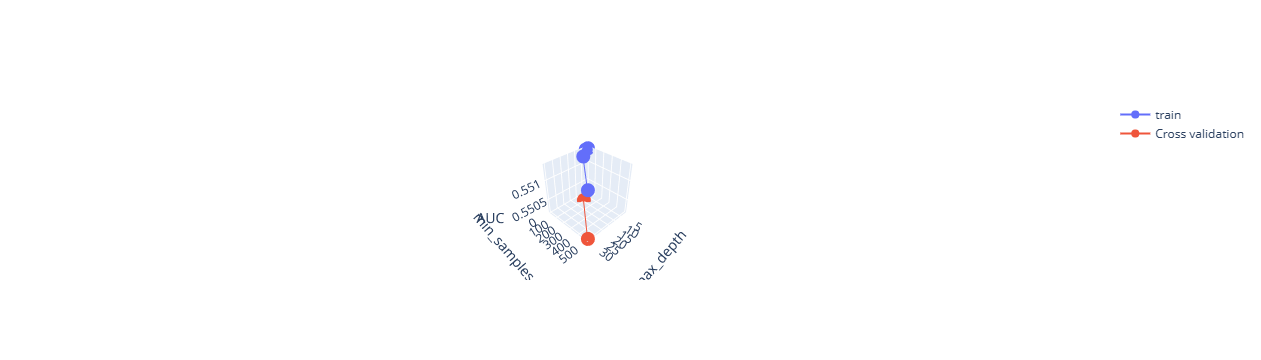

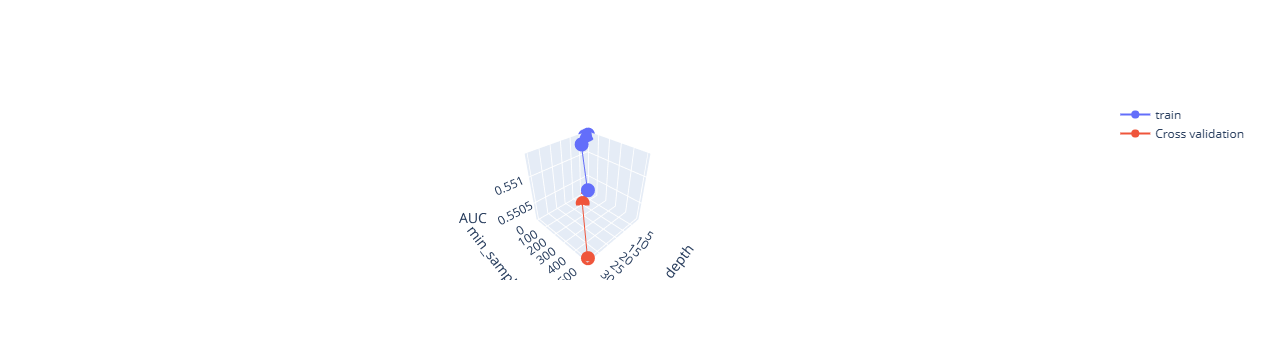

In [41]:

trace1 = go.Scatter3d(x=parameters['max_depth'],y= parameters['min_samples_split'],z=train_auc_set1_uni, name = 'train')
trace2 = go.Scatter3d(x=parameters['max_depth'],y= parameters['min_samples_split'],z=cv_auc_set1_uni, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='max_depth'),
        yaxis = dict(title='min_samples_split'),
        zaxis = dict(title='AUC'),))
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
fig.show()
plt.show()

#### Using best patameter to train model and check its scores for test data

In [42]:
dt_tfidf_uni = DecisionTreeClassifier(max_depth=10, min_samples_split=500,class_weight='balanced')
dt_tfidf_uni.fit(tfidf_train_set_uni,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

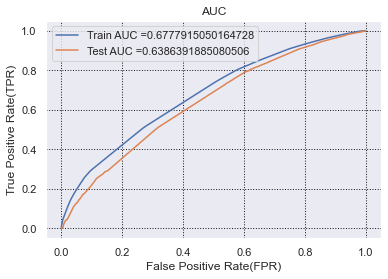

In [43]:
y_train_pred_uni=dt_tfidf_uni.predict_proba(tfidf_train_set_uni)[:,1]
y_test_pred_uni=dt_tfidf_uni.predict_proba(tfidf_test_set_uni)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_uni)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_uni)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

In [44]:
def predict(proba, threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)

    return predictions

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3738136137576351 for threshold 0.506
[[ 9188  3549]
 [34392 36991]]
the maximum value of tpr*(1-fpr) 0.3738136137576351 for threshold 0.506


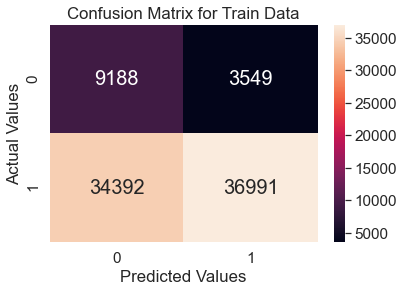

In [45]:
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred_uni, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred_uni, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3484925527228007 for threshold 0.506
[[ 2594  1211]
 [10423 10900]]
the maximum value of tpr*(1-fpr) 0.3484925527228007 for threshold 0.506


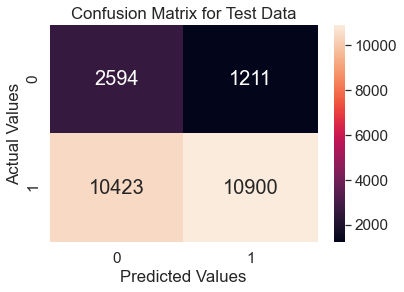

In [46]:

print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred_uni, te_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred_uni, te_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 20}, fmt='g')

plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

##### Finding False positives for essays, teacher_number_of_previously_posted_projects and price

In [47]:
test_predictions =  predict(y_test_pred_uni,tr_thresholds,test_fpr,test_tpr)

the maximum value of tpr*(1-fpr) 0.3484925527228007 for threshold 0.506


In [48]:
fp_essay_test = []
fp_no_of_ppp_test = []
fp_price_test = []

count = 0

for i in tqdm(range(len(y_test))):
    if(y_test.values[i] == 0) and (test_predictions[i] == 1):
        count += 1
        fp_essay_test.append(x_test['essay'].values[i])
        fp_no_of_ppp_test.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
        fp_price_test.append(x_test['price'].values[i])
        
print(count)

  0%|          | 0/25128 [00:00<?, ?it/s]

1211


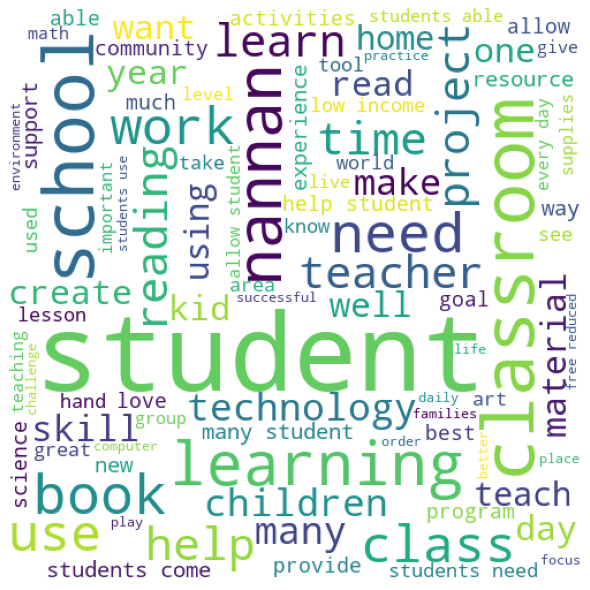

In [50]:
comment_words = ''

for words in fp_essay_test: 
    val = words.split()
    comment_words += " ".join(val)+" "


wordcloud = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image        
#plt.title("Wordcloud for Essay in test dataset")
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
    
plt.show()

From the above word-cloud we can conclude that words like <b> "studnet","classroom","reading","technology","learning" etc.</b> are affecting the model, which might result the model to preoduce false positives.

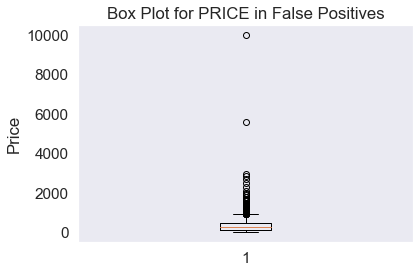

In [51]:
plt.boxplot(fp_price_test)
plt.title('Box Plot for PRICE in False Positives')
plt.ylabel('Price')
plt.grid()
plt.show()

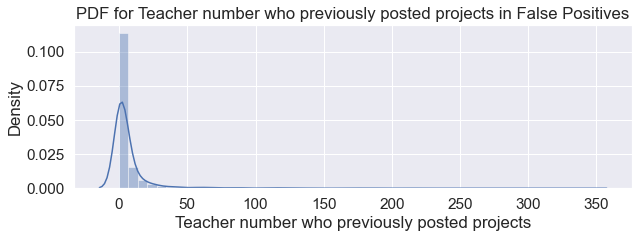

In [52]:
plt.figure(figsize=(10,3))
sns.distplot(fp_no_of_ppp_test)
plt.title('PDF for Teacher number who previously posted projects in False Positives')
plt.xlabel('Teacher number who previously posted projects')
plt.show()

> <h3>Training using data containing both unigrams and bigrams

In [53]:
#dt_classifier_set1 = DecisionTreeClassifier()
#parameters = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}
#grid_search = GridSearchCV(dt_classifier_set1,parameters, cv= 5, scoring='roc_auc',return_train_score=True,n_jobs=-1)

grid_search.fit(tfidf_train_set_bi, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [54]:
train_auc_set1_bi= grid_search.cv_results_['mean_train_score']
train_auc_std_set1_bi= grid_search.cv_results_['std_train_score']
cv_auc_set1_bi = grid_search.cv_results_['mean_test_score']
cv_auc_std_set1_bi= grid_search.cv_results_['std_test_score']
bestMaxDepth_set1_bi=grid_search.best_params_['max_depth']
bestMinSampleSplit_set1_bi=grid_search.best_params_['min_samples_split']
bestScore_set1_bi=grid_search.best_score_

In [55]:
print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

Train Scores: [0.55307736 0.55307736 0.55307736 0.55307736 0.59094101 0.59094101
 0.59094101 0.59094101 0.6650575  0.66434944 0.6600399  0.65773859
 0.77863294 0.77369661 0.75445333 0.72958849]
CV Scores :[0.55211332 0.55211332 0.55211332 0.55211332 0.58489326 0.58489326
 0.58489326 0.58489326 0.62313189 0.62322557 0.62680811 0.62866157
 0.57691023 0.58109745 0.59467454 0.61592051]


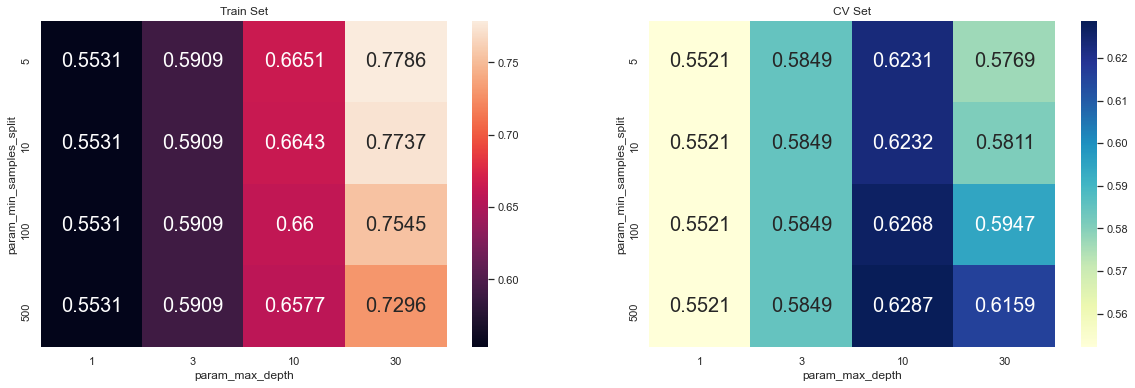

In [56]:
#plotting heat map to analys teh best parameters for the model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(grid_search.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [57]:
print("BEST MAX DEPTH: ",grid_search.best_params_['max_depth'],"\nBEST SCORE: ",grid_search.best_score_,"\nBEST MIN SAMPLE SPLIT: ",grid_search.best_params_['min_samples_split'])

BEST MAX DEPTH:  10 
BEST SCORE:  0.6286615674513777 
BEST MIN SAMPLE SPLIT:  500


In [58]:
dt_tfidf_bi = DecisionTreeClassifier(max_depth=10, min_samples_split=500,class_weight='balanced')
dt_tfidf_bi.fit(tfidf_train_set_bi,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

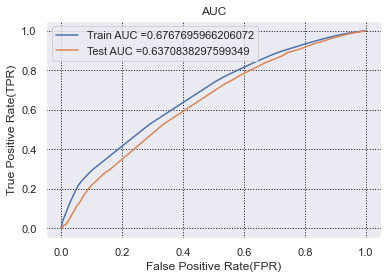

In [59]:

y_train_pred_bi=dt_tfidf_bi.predict_proba(tfidf_train_set_bi)[:,1]
y_test_pred_bi=dt_tfidf_bi.predict_proba(tfidf_test_set_bi)[:,1]

train_fpr_bi, train_tpr_bi, tr_thresholds_bi = roc_curve(y_train, y_train_pred_bi)
test_fpr_bi, test_tpr_bi, te_thresholds_bi = roc_curve(y_test, y_test_pred_bi)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr_bi, train_tpr_bi, label="Train AUC ="+str(auc(train_fpr_bi, train_tpr_bi)))
plt.plot(test_fpr_bi, test_tpr_bi, label="Test AUC ="+str(auc(test_fpr_bi, test_tpr_bi)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.37414237120057353 for threshold 0.515
[[ 9032  3705]
 [33720 37663]]
the maximum value of tpr*(1-fpr) 0.37414237120057353 for threshold 0.515


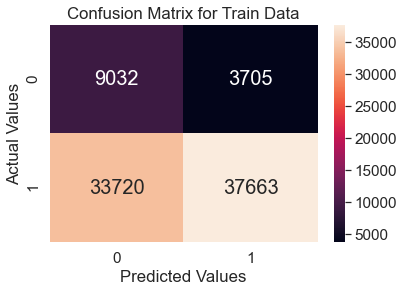

In [60]:
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred_bi, tr_thresholds_bi, train_fpr_bi, train_tpr_bi)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred_bi, tr_thresholds_bi,train_fpr_bi, train_tpr_bi)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3495124455507348 for threshold 0.515
[[ 2546  1259]
 [10185 11138]]
the maximum value of tpr*(1-fpr) 0.3495124455507348 for threshold 0.515


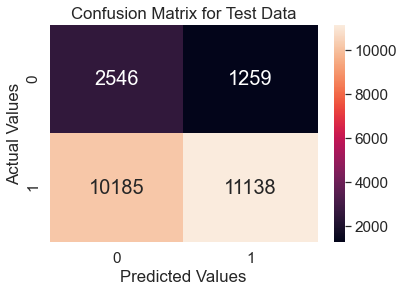

In [61]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred_bi, te_thresholds_bi, test_fpr_bi, test_tpr_bi)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred_bi, te_thresholds_bi, test_fpr_bi, test_tpr_bi)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

##### Finding False positives for essays, teacher_number_of_previously_posted_projects and price

In [62]:
test_predictions_bi = predict(y_test_pred_bi,tr_thresholds_bi,test_fpr_bi,test_tpr_bi)

the maximum value of tpr*(1-fpr) 0.3495124455507348 for threshold 0.515


In [63]:
fp_essay_test_bi = []
fp_no_of_ppp_test_bi = []
fp_price_test_bi = []

count = 0

for i in tqdm(range(len(y_test))):
    if(y_test.values[i] == 0) and (test_predictions_bi[i] == 1):
        count += 1
        fp_essay_test_bi.append(x_test['essay'].values[i])
        fp_no_of_ppp_test_bi.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
        fp_price_test_bi.append(x_test['price'].values[i])
        
print(count)

  0%|          | 0/25128 [00:00<?, ?it/s]

1259


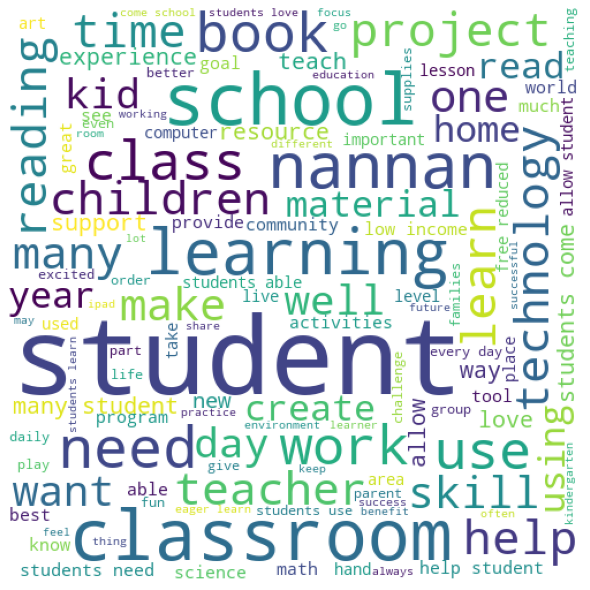

In [64]:
#wordcloud
comment_words = ''

for words in fp_essay_test_bi: 
    val = words.split()
    comment_words += " ".join(val)+" "


wordcloud = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image        
#plt.title("Wordcloud for Essay in test dataset")
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
    
plt.show()

From the above word-cloud we can conclude that words like <b> "studnet","classroom","need","children","learning" etc.</b> are affecting the model, which might result the model to preoduce false positives.

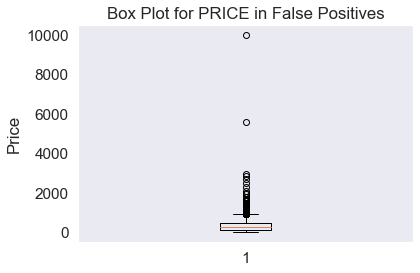

In [65]:
plt.boxplot(fp_price_test_bi)
plt.title('Box Plot for PRICE in False Positives')
plt.ylabel('Price')
plt.grid()
plt.show()

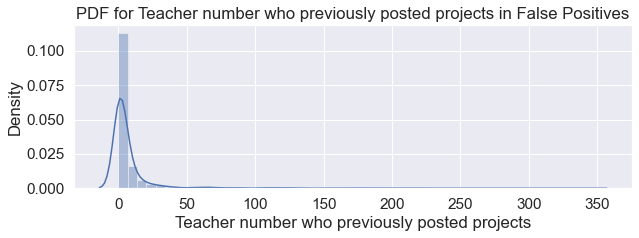

In [66]:
plt.figure(figsize=(10,3))
sns.distplot(fp_no_of_ppp_test_bi)
plt.title('PDF for Teacher number who previously posted projects in False Positives')
plt.xlabel('Teacher number who previously posted projects')
plt.show()

> <h2> For Set 2(Data with unigrams and bigrams)

In [67]:
dt_classifier_set2 = DecisionTreeClassifier()
parameters = {'max_depth':[1, 3, 10, 30],'min_samples_split':[5, 10, 100, 500]}
grid_search = GridSearchCV(dt_classifier_set2,parameters, cv= 5, scoring='roc_auc',return_train_score=True,n_jobs=-1)

grid_search.fit(w2v_train_set, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [68]:
train_auc_set2= grid_search.cv_results_['mean_train_score']
train_auc_std_set2= grid_search.cv_results_['std_train_score']
cv_auc_set2 = grid_search.cv_results_['mean_test_score']
cv_auc_std_set2= grid_search.cv_results_['std_test_score']
bestMaxDepth_set2=grid_search.best_params_['max_depth']
bestMinSampleSplit_set2=grid_search.best_params_['min_samples_split']
bestScore_set2=grid_search.best_score_

In [69]:
print("Train Scores: "+ str(grid_search.cv_results_['mean_train_score']))
print("CV Scores :" + str(grid_search.cv_results_['mean_test_score']))

Train Scores: [0.55770679 0.55770679 0.55770679 0.55770679 0.6150809  0.6150809
 0.6150809  0.6150809  0.74102402 0.73968134 0.72660561 0.70656273
 0.98879068 0.9839372  0.91243177 0.78255566]
CV Scores :[0.55556676 0.55556676 0.55556676 0.55556676 0.60558799 0.60558799
 0.60558799 0.60558799 0.59929009 0.59954087 0.60688323 0.61298176
 0.49439316 0.50093823 0.55639988 0.60108989]


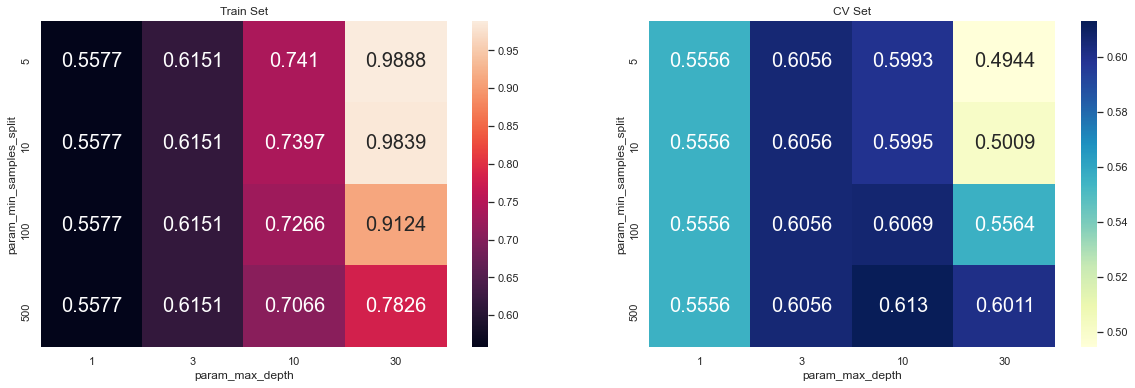

In [70]:
#plotting heat map to analys teh best parameters for the model
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

max_scores1 = pd.DataFrame(grid_search.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [71]:
print("BEST MAX DEPTH: ",grid_search.best_params_['max_depth'],"\nBEST SCORE: ",grid_search.best_score_,"\nBEST MIN SAMPLE SPLIT: ",grid_search.best_params_['min_samples_split'])

BEST MAX DEPTH:  10 
BEST SCORE:  0.6129817593452513 
BEST MIN SAMPLE SPLIT:  500


In [72]:
dt_w2v = DecisionTreeClassifier(max_depth=10, min_samples_split=500,class_weight='balanced')
dt_w2v.fit(w2v_train_set,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

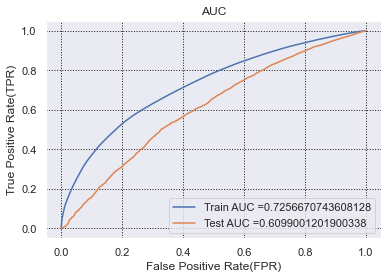

In [73]:

y_train_pred_w2v=dt_w2v.predict_proba(w2v_train_set)[:,1]
y_test_pred_w2v=dt_w2v.predict_proba(w2v_test_set)[:,1]

train_fpr_w2v, train_tpr_w2v, tr_thresholds_w2v = roc_curve(y_train, y_train_pred_w2v)
test_fpr_w2v, test_tpr_w2v, te_thresholds_w2v = roc_curve(y_test, y_test_pred_w2v)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr_w2v, train_tpr_w2v, label="Train AUC ="+str(auc(train_fpr_w2v, train_tpr_w2v)))
plt.plot(test_fpr_w2v, test_tpr_w2v, label="Test AUC ="+str(auc(test_fpr_w2v, test_tpr_w2v)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.4419154318783091 for threshold 0.472
[[ 9040  3697]
 [26937 44446]]
the maximum value of tpr*(1-fpr) 0.4419154318783091 for threshold 0.472


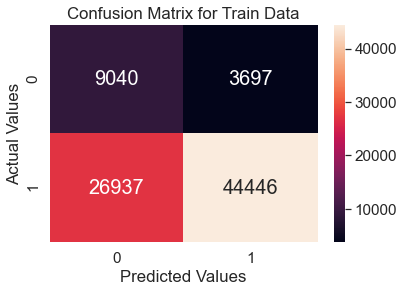

In [74]:
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_pred_w2v, tr_thresholds_w2v, train_fpr_w2v, train_tpr_w2v)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_pred_w2v, tr_thresholds_w2v,train_fpr_w2v, train_tpr_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.34061472244409446 for threshold 0.528
[[ 2440  1365]
 [ 9997 11326]]
the maximum value of tpr*(1-fpr) 0.34061472244409446 for threshold 0.528


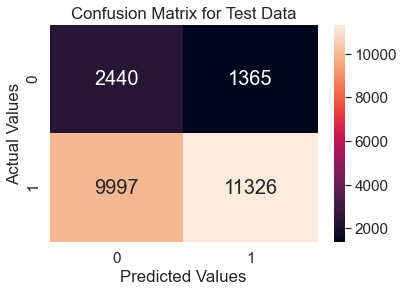

In [75]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_pred_w2v, te_thresholds_w2v, test_fpr_w2v, test_tpr_w2v)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_pred_w2v, te_thresholds_w2v, test_fpr_w2v, test_tpr_w2v)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

Find all the false positive data points and plot wordcloud of essay text and pdf of teacher_number_of_previously_posted_projects.

##### Finding False positives for essays, teacher_number_of_previously_posted_projects and price

In [76]:
test_predictions_w2v =  predict(y_test_pred_w2v,tr_thresholds_w2v,test_fpr_w2v,test_tpr_w2v)

the maximum value of tpr*(1-fpr) 0.34061472244409446 for threshold 0.528


In [77]:
fp_essay_test_w2v = []
fp_no_of_ppp_test_w2v = []
fp_price_test_w2v = []

count = 0

for i in tqdm(range(len(y_test))):
    if(y_test.values[i] == 0) and (test_predictions_w2v[i] == 1):
        count += 1
        fp_essay_test_w2v.append(x_test['essay'].values[i])
        fp_no_of_ppp_test_w2v.append(x_test['teacher_number_of_previously_posted_projects'].values[i])
        fp_price_test_w2v.append(x_test['price'].values[i])
        
print(count)

  0%|          | 0/25128 [00:00<?, ?it/s]

1365


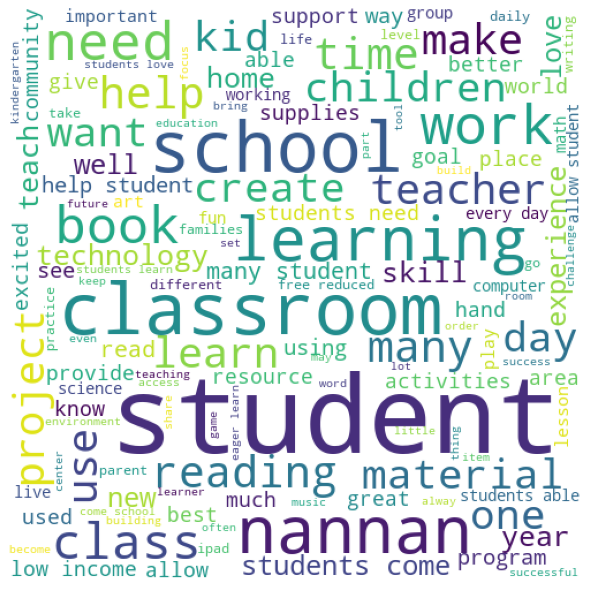

In [78]:
#wordcloud
comment_words = ''

for words in fp_essay_test_w2v: 
    val = words.split()
    comment_words += " ".join(val)+" "


wordcloud = WordCloud(width = 500, height = 500, background_color ='white', min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image        
#plt.title("Wordcloud for Essay in test dataset")
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
    
plt.show()

From the above word-cloud we can conclude that words like <b> "studnet","classroom","school","book","learning" etc.</b> are affecting the model, which might result the model to preoduce false positives.

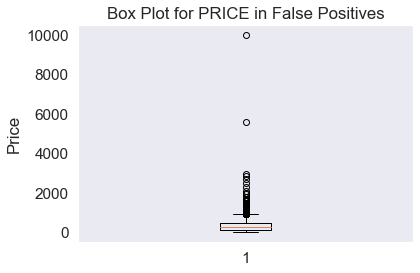

In [79]:
plt.boxplot(fp_price_test_bi)
plt.title('Box Plot for PRICE in False Positives')
plt.ylabel('Price')
plt.grid()
plt.show()

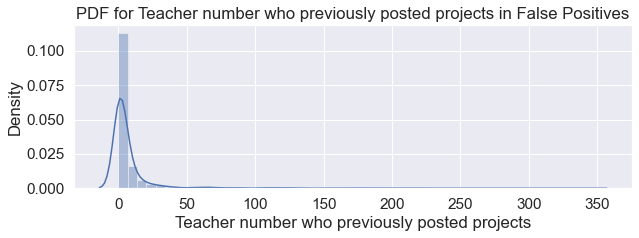

In [80]:
plt.figure(figsize=(10,3))
sns.distplot(fp_no_of_ppp_test_bi)
plt.title('PDF for Teacher number who previously posted projects in False Positives')
plt.xlabel('Teacher number who previously posted projects')
plt.show()

<font color='blue'><b>Extracting all non-zero features</b></font>

In [82]:
dt_class2 =  DecisionTreeClassifier()

dt_class2.fit(tfidf_train_set_bi,y_train) #using the dataset containing both unigrams and bigrams as features

DecisionTreeClassifier()

In [92]:
# dt_class2.feature_importances_

zero_featue_indexes = []

for index in tqdm(range(len(dt_class2.feature_importances_))):
    if (dt_class2.feature_importances_[index]==0):
        zero_featue_indexes.append(index)

print(len(zero_featue_indexes))

  0%|          | 0/19152 [00:00<?, ?it/s]

14699


In [99]:
tfidf_trainset_arr = tfidf_train_set_bi.toarray()
tfidf_testset_arr = tfidf_test_set_bi.toarray()

In [101]:
print("Shape of Train dataset : ",tfidf_trainset_arr.shape)
print("Shape of Test dataset : ",tfidf_testset_arr.shape)

tfidf_trainset_arr = np.delete(tfidf_trainset_arr, zero_featue_indexes, axis=1)
tfidf_testset_arr = np.delete(tfidf_testset_arr, zero_featue_indexes, axis=1)

print("Shape of Train datasetn after dropping features with zero importance : ",tfidf_trainset_arr.shape)
print("Shape of Test dataset after dropping features with zero importance : ",tfidf_testset_arr.shape)

Shape of Train dataset :  (84120, 19152)
Shape of Test dataset :  (25128, 19152)
Shape of Train datasetn after dropping features with zero importance :  (84120, 4453)
Shape of Test dataset after dropping features with zero importance :  (25128, 4453)


In [103]:
tfidf_trainset = sparse.csr_matrix(tfidf_trainset_arr)
tfdif_testset = sparse.csr_matrix(tfidf_testset_arr)

> Performing hyper-parameter tuning for DT model using only non_zero feature importance data

In [114]:
dt = DecisionTreeClassifier()

parameters = {'max_depth': [1, 3, 10, 30], 'min_samples_split': [5, 10, 100, 500]}

gs = GridSearchCV(dt ,parameters ,cv = 5 , scoring="roc_auc", return_train_score=True, verbose=1, n_jobs=-1)
gs.fit(tfidf_trainset,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [115]:
train_auc_score = gs.cv_results_['mean_train_score']
train_auc_std_score = gs.cv_results_['std_train_score']
cv_auc_score = gs.cv_results_['mean_test_score']
cv_auc_std_score = gs.cv_results_['std_test_score']
bestMaxDepth = gs.best_params_['max_depth']
bestMinSampleSpli = gs.best_params_['min_samples_split']
bestScore = gs.best_score_

In [116]:
print("Train Scores: "+ str(gs.cv_results_['mean_train_score']))
print("CV Scores :" + str(gs.cv_results_['mean_test_score']))

Train Scores: [0.55307736 0.55307736 0.55307736 0.55307736 0.59094101 0.59094101
 0.59094101 0.59094101 0.66622312 0.66560125 0.66076087 0.65800623
 0.79077259 0.78558534 0.76143937 0.7328638 ]
CV Scores :[0.55211332 0.55211332 0.55211332 0.55211332 0.58489326 0.58489326
 0.58489326 0.58489326 0.62136456 0.62207657 0.62620584 0.62869569
 0.57582218 0.58045416 0.59929931 0.62239484]


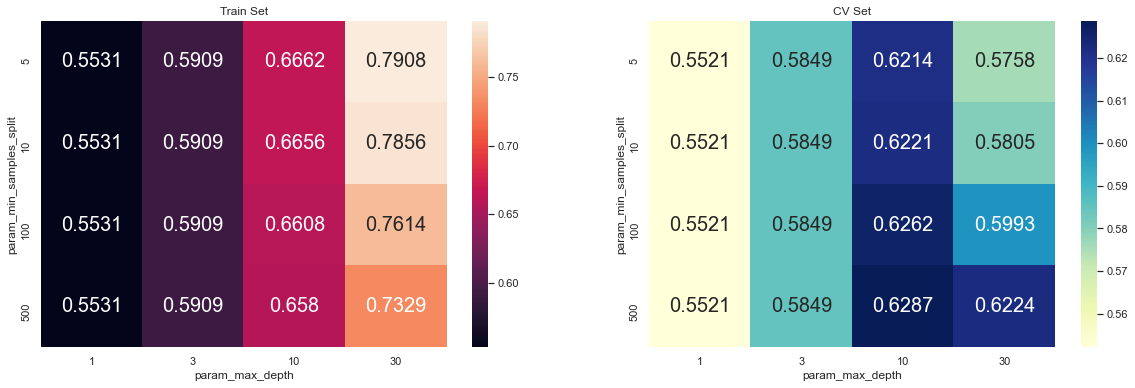

In [117]:
max_scores = pd.DataFrame(gs.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 20})
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 20},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

In [118]:
print("BEST MAX DEPTH: ",grid_search.best_params_['max_depth'],"\nBEST SCORE: ",grid_search.best_score_,"\nBEST MIN SAMPLE SPLIT: ",grid_search.best_params_['min_samples_split'])

BEST MAX DEPTH:  10 
BEST SCORE:  0.6286668802270923 
BEST MIN SAMPLE SPLIT:  500


#### Fitting the data using the best parameters

In [120]:
dt_best_param = DecisionTreeClassifier(max_depth= 10, min_samples_split=500, class_weight='balanced')
dt_best_param.fit(tfidf_trainset,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=500)

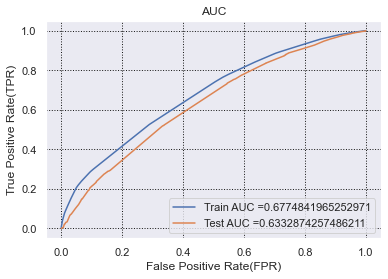

In [122]:
y_train_predictions =dt_best_param.predict_proba(tfidf_trainset)[:,1]
y_test_predictions =dt_best_param.predict_proba(tfdif_testset)[:,1]       # name of test set was a typo in starting "tfdif_testset"

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_predictions)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_predictions)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.show()

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.37394865147014744 for threshold 0.504
[[ 9035  3702]
 [33752 37631]]
the maximum value of tpr*(1-fpr) 0.37394865147014744 for threshold 0.504


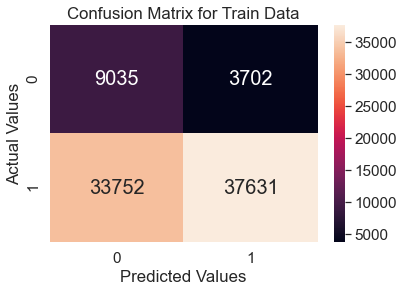

In [123]:
print("Train confusion matrix")
print(confusion_matrix(y_train, predict(y_train_predictions, tr_thresholds, train_fpr, train_tpr)))

conf_matr_df_train = pd.DataFrame(confusion_matrix(y_train, predict(y_train_predictions, tr_thresholds,train_fpr, train_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_train, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Train Data")
plt.show()

Test confusion matrix
the maximum value of tpr*(1-fpr) 0.346217748499196 for threshold 0.504
[[ 2522  1283]
 [10185 11138]]
the maximum value of tpr*(1-fpr) 0.346217748499196 for threshold 0.504


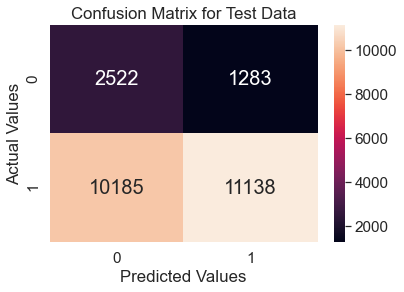

In [124]:
print("Test confusion matrix")
print(confusion_matrix(y_test, predict(y_test_predictions, te_thresholds, test_fpr, test_tpr)))

conf_matr_df_test = pd.DataFrame(confusion_matrix(y_test, predict(y_test_predictions, te_thresholds, test_fpr, test_tpr)), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_df_test, annot=True,annot_kws={"size": 20}, fmt='g')


plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Confusion Matrix for Test Data")
plt.show()

<h3>Tabulation of Results

In [125]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "min_sample_split","max_depth", "Train AUC", "Test AUC"]
table.add_row(["TFIDF using unigrams", "Decision Tree", 10,500, 0.6778,0.6386])
table.add_row(["TFIDF using both unigrams and bigrams ", "Decision Tree", 10,500, 0.6768,0.6371])
table.add_row(["TFIDF-W2V", "Decision Tree", 10,500, 0.7257,0.6099])
table.add_row(["TFIDF using non-zero feature importance", "Decision Tree", 10,500, 0.6774,0.6332])

print(table)

+-----------------------------------------+---------------+------------------+-----------+-----------+----------+
|                Vectorizer               |     Model     | min_sample_split | max_depth | Train AUC | Test AUC |
+-----------------------------------------+---------------+------------------+-----------+-----------+----------+
|           TFIDF using unigrams          | Decision Tree |        10        |    500    |   0.6778  |  0.6386  |
|  TFIDF using both unigrams and bigrams  | Decision Tree |        10        |    500    |   0.6768  |  0.6371  |
|                TFIDF-W2V                | Decision Tree |        10        |    500    |   0.7257  |  0.6099  |
| TFIDF using non-zero feature importance | Decision Tree |        10        |    500    |   0.6774  |  0.6332  |
+-----------------------------------------+---------------+------------------+-----------+-----------+----------+
